In [ ]:
!pip install --upgrade transformers

In [ ]:
# Install HuggingFace Transformers and other libraries
!pip install -q transformers datasets shap accelerate
!pip install -q git+https://github.com/huggingface/trl.git  # For RLHF tools (PPO, REINFORCE)

# For visualization
!pip install -q matplotlib seaborn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/ML Final Group Project/train.csv"
df = pd.read_csv(file_path)

# Filter relevant columns
df = df[['comment_text', 'toxic']]

# Preview
df.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
from sklearn.model_selection import train_test_split
# Keep only relevant columns
df = df[['comment_text', 'toxic']]

# Stratified sample of 50,000 rows
df, _ = train_test_split(
    df,
    train_size=50000,
    stratify=df['toxic'],
    random_state=42
)

# Reset index
df = df.reset_index(drop=True)

# Preview stratified sample
df['toxic'].value_counts(normalize=True)

,proportion
toxic,
0,0.90416
1,0.09584


In [ ]:
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['comment_text'].tolist(),
    df['toxic'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize the input text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [ ]:
import torch

# Custom dataset class
class ToxicCommentsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# Wrap the encodings in the Dataset
train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset   = ToxicCommentsDataset(val_encodings, val_labels)

In [ ]:
from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT model with 2 output classes (toxic or not)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./toxicity_model_output",      # Directory to save checkpoints and logs
    num_train_epochs=3,                        # Number of training epochs
    per_device_train_batch_size=16,            # Batch size for training
    per_device_eval_batch_size=64,             # Batch size for evaluation
    learning_rate=2e-5,                        # Learning rate
    eval_strategy="epoch",                     # Evaluate at the end of each epoch
    save_strategy="epoch",                    # Save checkpoint at end of each epoch
    logging_dir="./logs",                     # Directory for logs
    logging_steps=100,
    load_best_model_at_end=True,              # Keep best model based on eval loss
    metric_for_best_model="f1",
    save_total_limit=2,                         # Save only last 2 checkpoints to save space
    report_to='none'
)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Compute accuracy, precision, recall, f1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
        "f1": f1_score(labels, preds, average="binary")
    }

# Initialize Trainer
trainer = Trainer(
    model=model,  # already loaded earlier (e.g. AutoModelForSequenceClassification)
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-759045632.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.107600,0.101958,0.966200,0.943536,0.679144,0.789801
2,0.060200,0.107856,0.969900,0.851441,0.821390,0.836146
3,0.032000,0.130384,0.969100,0.843956,0.821390,0.832520


TrainOutput(global_step=7500, training_loss=0.07680088547070821, metrics={'train_runtime': 1578.7855, 'train_samples_per_second': 76.008, 'train_steps_per_second': 4.75, 'total_flos': 3974021959680000.0, 'train_loss': 0.07680088547070821, 'epoch': 3.0})

In [ ]:
# Create output directory in Drive
output_dir = "/content/drive/MyDrive/ML Final Group Project/toxicity_model"

# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/ML Final Group Project/toxicity_model/tokenizer_config.json',
 '/content/drive/MyDrive/ML Final Group Project/toxicity_model/special_tokens_map.json',
 '/content/drive/MyDrive/ML Final Group Project/toxicity_model/vocab.txt',
 '/content/drive/MyDrive/ML Final Group Project/toxicity_model/added_tokens.json',
 '/content/drive/MyDrive/ML Final Group Project/toxicity_model/tokenizer.json')

In [ ]:
# ---------------------- Model Loading -------------------------------

In [ ]:
# Install and import required packages
!pip install transformers --quiet

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Load pre-trained model and tokenizer
model_path = "/content/drive/MyDrive/ML Final Group Project/toxicity_model"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

In [ ]:
# Define custom dataset class
class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Load test data
test_df = pd.read_csv("/content/drive/MyDrive/ML Final Group Project/test.csv")
print(test_df.columns)  # Debugging: See what columns exist

# Extract text and dummy labels (if no 'toxic' label available)
texts = test_df['comment_text'].tolist()
dummy_labels = [0] * len(test_df)  # Just to satisfy Dataset structure

# Tokenize and build dataset
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
test_dataset = ToxicCommentsDataset(encodings, dummy_labels)

Index(['id', 'comment_text'], dtype='object')


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Run predictions
trainer = Trainer(model=model)
outputs = trainer.predict(test_dataset)
logits = outputs.predictions
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Store predictions
test_df['predicted_label'] = preds
test_df['toxic_probability'] = probs[:, 1]  # prob of label=1 (toxic)

# Show sample predictions
test_df[['comment_text', 'predicted_label', 'toxic_probability']].head(10)

,comment_text,predicted_label,toxic_probability
0,Yo bitch Ja Rule is more succesful then you'll...,1,0.996461
1,== From RfC == \n\n The title is fine as it is...,0,0.000218
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0.000168
3,":If you have a look back at the source, the in...",0,0.000173
4,I don't anonymously edit articles at all.,0,0.000171
5,Thank you for understanding. I think very high...,0,0.000344
6,Please do not add nonsense to Wikipedia. Such ...,0,0.000146
7,:Dear god this site is horrible.,1,0.868973
8,""" \n Only a fool can believe in such numbers. ...",0,0.003168
9,== Double Redirects == \n\n When fixing double...,0,0.000130


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load full dataset
df = pd.read_csv("/content/drive/MyDrive/ML Final Group Project/train.csv")
df = df[['comment_text', 'toxic']]  # Keep relevant columns

# Stratified sample 50,000 rows (for balanced class distribution)
df_sampled, _ = train_test_split(df, train_size=50000, stratify=df['toxic'], random_state=42)

# Load tokenizer and model
model_path = "/content/drive/MyDrive/ML Final Group Project/toxicity_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenize
encodings = tokenizer(df_sampled['comment_text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Inference with batching + GPU + progress bar
batch_size = 32
all_preds = []

with torch.no_grad():
    for i in tqdm(range(0, len(df_sampled), batch_size), desc="Running Inference"):
        batch = {k: v[i:i+batch_size].to(device) for k, v in encodings.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(preds.cpu().numpy())

# Save predictions
df_sampled['predicted_label'] = all_preds

# Save result to CSV
output_path = "/content/drive/MyDrive/ML Final Group Project/sample_predictions.csv"
df_sampled.to_csv(output_path, index=False)
print(f"Saved predictions to {output_path}")

Running Inference: 100%|██████████| 1563/1563 [03:05<00:00,  8.41it/s]


Saved predictions to /content/drive/MyDrive/ML Final Group Project/sample_predictions.csv


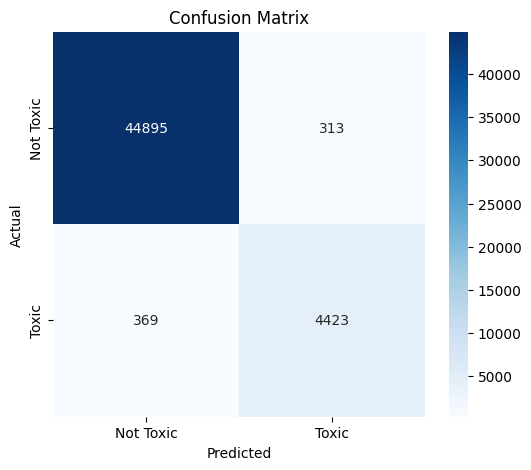

Classification Report:

              precision    recall  f1-score   support

   Not Toxic       0.99      0.99      0.99     45208
       Toxic       0.93      0.92      0.93      4792

    accuracy                           0.99     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.99      0.99      0.99     50000



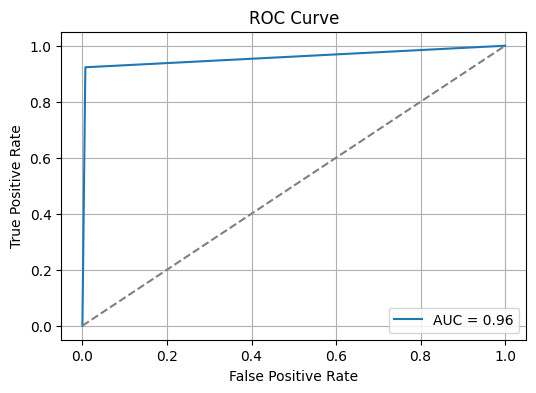

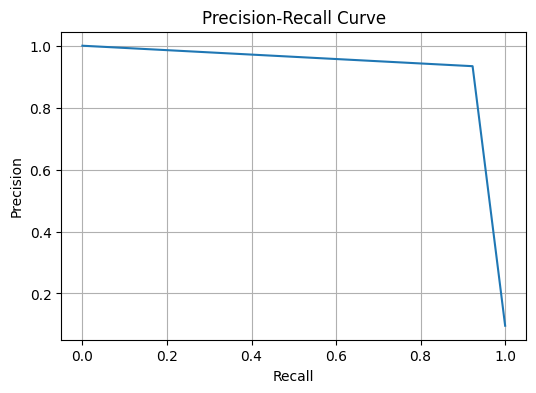

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

# Load saved predictions
df = pd.read_csv("/content/drive/MyDrive/ML Final Group Project/sample_predictions.csv")
y_true = df["toxic"]
y_pred = df["predicted_label"]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not Toxic", "Toxic"]))

# ROC Curve
y_score = df["predicted_label"]  # Since we only have hard labels (0/1), ROC will be binary
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [ ]:
# ------------------ GenAI Part ----------------------------

In [ ]:
!pip install -q requests pandas tqdm

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

# Sample toxic comments (you can replace this with your own dataset later)
toxic_comments = [
    "You're so dumb, nobody wants to hear you talk!",
    "That was a pathetic excuse for an answer.",
    "You're the worst person I've ever met.",
    "Why are you even allowed to speak?",
    "Get lost, nobody needs you here."
]

# Prepare DataFrame
df = pd.DataFrame(toxic_comments, columns=['toxic_comment'])

# Function to generate moderation suggestion using OpenRouter (free models)
def get_moderation_suggestion(comment, api_key):
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "mistralai/mistral-7b-instruct",  # You can try others like llama3
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a moderation assistant. Given a toxic or harmful comment, "
                    "you must explain why it's inappropriate and suggest a moderation action "
                    "(e.g., warning, mute, ban) based on severity. Be specific but concise."
                )
            },
            {
                "role": "user",
                "content": comment
            }
        ],
        "temperature": 0.7
    }
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()['choices'][0]['message']['content']
    except Exception as e:
        return f"Error: {e}"

In [ ]:
# Only run once per session
api_key = "api-key"  # Your real OpenRouter key here

In [ ]:
# You’ll be prompted to enter your OpenRouter API key
api_key = "api-key"  # Your real OpenRouter key here

# Store moderation results
moderation_suggestions = []

print("Generating moderation guidance for each toxic comment...")

for comment in tqdm(df['toxic_comment'], desc="Processing"):
    suggestion = get_moderation_suggestion(comment, api_key)
    moderation_suggestions.append(suggestion)

# Add results to DataFrame
df['moderation_action'] = moderation_suggestions

# Show results
df[['toxic_comment', 'moderation_action']].head()

Generating moderation guidance for each toxic comment...


Processing: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


,toxic_comment,moderation_action
0,"You're so dumb, nobody wants to hear you talk!",<s> [OUT] This comment is inappropriate becau...
1,That was a pathetic excuse for an answer.,<s> [OUT] The comment is toxic and disrespect...
2,You're the worst person I've ever met.,<s> [OUT] This comment is highly inappropriat...
3,Why are you even allowed to speak?,This comment is inappropriate because it's de...
4,"Get lost, nobody needs you here.",[OUT]\n\n**Explanation:** This comment is tox...


In [ ]:
def assess_and_moderate(comment, api_key):
    import requests

    system_prompt = (
        "You are a helpful AI assistant that classifies whether a comment is toxic or safe. "
        "If it's toxic, explain why and suggest a moderation action (warn, mute, ban). "
        "If it’s not toxic, simply say: 'Comment is safe to use.'"
    )

    payload = {
        "model": "mistralai/mixtral-8x7b-instruct",  # You can change to another OpenRouter-compatible model
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Comment: {comment}"}
        ]
    }

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.post("https://openrouter.ai/api/v1/chat/completions", json=payload, headers=headers)
        return response.json()["choices"][0]["message"]["content"]
    except Exception as e:
        return f"Error: {e}"

# User input
user_comment = input("Enter a comment to check: ")

# Process
result = assess_and_moderate(user_comment, api_key)

# Output
print(f"\nComment:\n{user_comment}")
print(f"\nModeration Result:\n{result}")

Enter a comment to check: You are dumb

Comment:
You are dumb

Moderation Result:
The comment "You are dumb" can be considered toxic as it is disrespectful and can be hurtful to the person it is directed towards. It can lead to a negative environment and potentially escalate conflicts.

As a moderation action, I would suggest giving the user a warning and requesting them to refrain from making such comments in the future. Repeated toxic behavior should be met with stricter consequences such as muting or banning the user to maintain a positive and respectful community.

However, if the comment was not directed at any specific person and was just a random outburst, it's still not appropriate and can be seen as disruptive. In this case, a gentle reminder about the community guidelines and the importance of maintaining a respectful and positive environment can be helpful.


In [ ]:
import gradio as gr
import requests

def assess_and_moderate(comment, api_key):
    system_prompt = (
        "You are a helpful AI assistant that classifies whether a comment is toxic or safe. "
        "If it's toxic, explain why and suggest a moderation action (warn, mute, ban). "
        "If it’s not toxic, simply say: 'Comment is safe to use.'"
    )

    payload = {
        "model": "mistralai/mixtral-8x7b-instruct",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Comment: {comment}"}
        ]
    }

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.post("https://openrouter.ai/api/v1/chat/completions", json=payload, headers=headers)
        return response.json()["choices"][0]["message"]["content"]
    except Exception as e:
        return f"Error: {e}"

with gr.Blocks(theme=gr.themes.Base(primary_hue="orange", secondary_hue="blue")) as demo:
    gr.Markdown(
        """
        <div style="text-align: center; padding: 10px 0;">
            <h1 style="font-size: 2.5rem;">🛡️ AI Comment Moderator</h1>
            <p style="font-size: 1.1rem; color: #cccccc;">
                Identify toxic comments and auto-suggest moderation actions with <b>GenAI</b> via <a href="https://openrouter.ai" target="_blank">OpenRouter</a>.
            </p>
        </div>
        """,
        elem_id="header"
    )

    with gr.Row():
        with gr.Column(scale=1):
            with gr.Group():
                comment_input = gr.Textbox(
                    label="💬 Comment to Check",
                    placeholder="e.g. You are so dumb...",
                    lines=3,
                    container=True,
                    show_label=True
                )

                api_input = gr.Textbox(
                    label="🔑 OpenRouter API Key",
                    type="password",
                    placeholder="Paste your API key here...",
                    show_label=True
                )

                submit_btn = gr.Button("🚀 Analyze Comment", variant="primary")

        with gr.Column(scale=1.3):
            result_output = gr.Textbox(
                label="🧾 Moderation Output",
                lines=10,
                show_copy_button=True,
                interactive=False
            )

    submit_btn.click(fn=assess_and_moderate, inputs=[comment_input, api_input], outputs=result_output)

    gr.Markdown(
        """
        <div style="text-align: center; font-size: 0.9rem; margin-top: 30px; color: gray;">
            Built with using <a href="https://gradio.app" target="_blank">Gradio</a> • Powered by <a href="https://openrouter.ai" target="_blank">OpenRouter AI</a>
        </div>
        """
    )

demo.launch()

/tmp/ipython-input-966748272.py:30: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Base(primary_hue="orange", secondary_hue="blue")) as demo:
/usr/local/lib/python3.12/dist-packages/gradio/layouts/column.py:59: UserWarning: 'scale' value should be an integer. Using 1.3 will cause issues.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b5119b50001f39167.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
